In [92]:
import warnings
warnings.filterwarnings("ignore")
#Data Manipulation and Treatment
import numpy as np
import pandas as pd
from datetime import datetime
#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats
import itertools
#Scikit-Learn for Modeling
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
#dvc
import dvc.api
import mlflow
#utils 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import plot

In [90]:
def str_to_date(date):
    return datetime.strptime(date, '%Y-%m-%d').date()

In [81]:
train_data = pd.read_csv(r'C:\Users\Hp\Downloads/train.csv')
test_data =  pd.read_csv(r'C:\Users\Hp\Downloads/test.csv')
store_data = pd.read_csv(r'C:\Users\Hp\Downloads/store.csv')
sample_submission_data = pd.read_csv(r'C:\Users\Hp\Downloads/sample_submission.csv')

In [82]:
train_data.head() 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [43]:
train_data.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [42]:
train_data.dtypes,print ("The Train dataset has {} Rows and {} Variables".format(str(train_data.shape[0]),str(train_data.shape[1])))

The Train dataset has 1017209 Rows and 9 Variables


(Store             int64
 DayOfWeek         int64
 Date             object
 Sales             int64
 Customers         int64
 Open              int64
 Promo             int64
 StateHoliday     object
 SchoolHoliday     int64
 dtype: object,
 None)

In [44]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [45]:
test_data.tail()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
41087,41088,1115,6,2015-08-01,1.0,0,0,1


In [47]:
test_data.dtypes,print ("The Test dataset has {} Rows and {} Variables".format(str(test_data.shape[0]),str(test_data.shape[1])))

The Test dataset has 41088 Rows and 8 Variables


(Id                 int64
 Store              int64
 DayOfWeek          int64
 Date              object
 Open             float64
 Promo              int64
 StateHoliday      object
 SchoolHoliday      int64
 dtype: object,
 None)

<b>Check for distribution in both training and test sets</b>

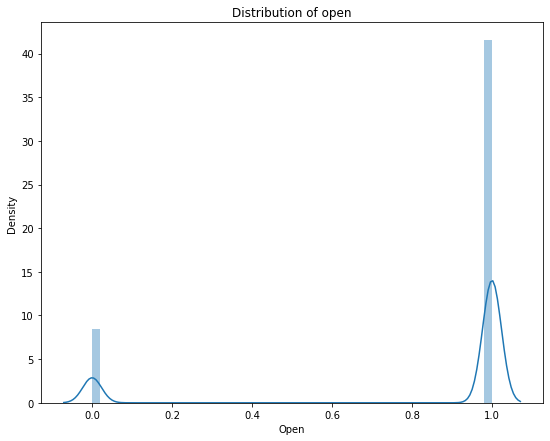

In [51]:
plt.figure(figsize=(9, 7))
sns.distplot(train_data['Open']).set_title(f'Distribution of open')
plt.show()

In [52]:
train_data.Promo.describe()

count    1.017209e+06
mean     3.815145e-01
std      4.857586e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: Promo, dtype: float64

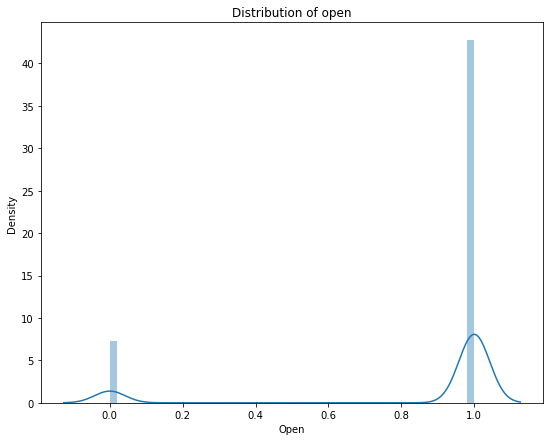

In [53]:
plt.figure(figsize=(9, 7))
sns.distplot(test_data['Open']).set_title(f'Distribution of open')
plt.show()

In [54]:
test_data.Promo.describe()

count    41088.000000
mean         0.395833
std          0.489035
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Promo, dtype: float64

#<b>Data Wrangling and Exploration:</b>

How many missing fields each variable has ?

In [56]:
train_data.count(0)/train_data.shape[0] * 100

Store            100.0
DayOfWeek        100.0
Date             100.0
Sales            100.0
Customers        100.0
Open             100.0
Promo            100.0
StateHoliday     100.0
SchoolHoliday    100.0
dtype: float64

We can see that the the columns have got a good fill rate. We don't need to do any change for the train set for now.

In [57]:
print ()
print ("-Over those two years, {} is the number of times that different stores closed on given days.".format(train_data[(train_data.Open == 0)].count()[0]))
print ()
print ("-From those closed events, {} times occured because there was a school holiday. " .format(train_data[(train_data.Open == 0) & (train_data.SchoolHoliday == 1)&(train_data.StateHoliday == '0') ].count()[0]))
print ()
print ("-And {} times it occured because of either a bank holiday or easter or christmas.".format(train_data[(train_data.Open == 0) &
         ((train_data.StateHoliday == 'a') |
          (train_data.StateHoliday == 'b') | 
          (train_data.StateHoliday == 'c'))].count()[0]))
print ()
print ("-But interestingly enough, {} times those shops closed on days for no apparent reason when no holiday was announced. In fact, those closings were done with no pattern whatsoever and in this case from 2013 to 2015 at almost any month and any day.".format(train_data[(train_data.Open == 0) &
         (train_data.StateHoliday == "0")
         &(train_data.SchoolHoliday == 0)].count()[0]))
print ()


-Over those two years, 172817 is the number of times that different stores closed on given days.

-From those closed events, 2263 times occured because there was a school holiday. 

-And 30140 times it occured because of either a bank holiday or easter or christmas.

-But interestingly enough, 121482 times those shops closed on days for no apparent reason when no holiday was announced. In fact, those closings were done with no pattern whatsoever and in this case from 2013 to 2015 at almost any month and any day.



After reading the descrition of the this task,  we cann see it  clearly that we are going  undergoing refurbishments sometimes and have to close. Most probably those were the times this event was happening.

And since we don't want to bias our decision tree models to consider those exceptions, the best solution here is to get rid of closed stores and prevent the models to train on them and get false guidance.

In this case we will analyse only open stores since a close store yield a profit of 0.

In [58]:
train_data=train_data.drop(train_data[(train_data.Open == 0) & (train_data.Sales == 0)].index)

In [59]:
train_data =train_data.reset_index(drop=True) #making sure the indexes are back to [0,1,2,3 etc.] 

In [60]:
print ("Our new training set has now {} rows ".format(train_data.shape[0]))

Our new training set has now 844392 rows 


<b>What about the distribution of Sales and Customers in the train set and test set? Any outliers?</b>



1) Sales:

In [62]:
train_data.Sales.describe()

count    844392.000000
mean       6955.514291
std        3104.214680
min           0.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64

we see here a minimum of 0 which means some stores even opened got 0 sales on some days.

In [63]:
train_data=train_data.drop(train_data[(train_data.Open == 1) & (train_data.Sales == 0)].index)
train_data =train_data.reset_index(drop=True) 

{'Mean': 6955.959133664481, 'Median': 6369.0}

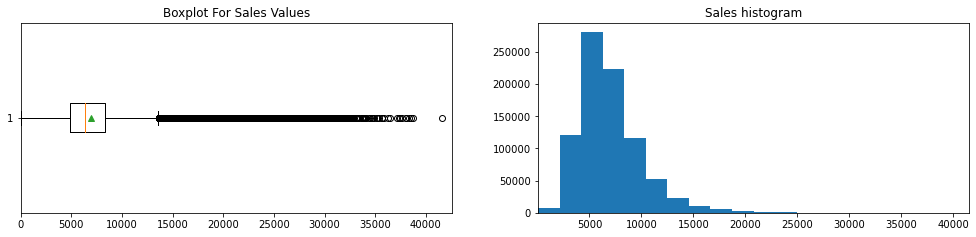

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].boxplot(train_data.Sales, showmeans=True,vert=False)
axes[0].set_xlim(0,max(train_data["Sales"]+1000))
axes[0].set_title('Boxplot For Sales Values')
axes[1].hist(train_data.Sales, cumulative=False, bins=20)
axes[1].set_title("Sales histogram")
axes[1].set_xlim((min(train_data.Sales), max(train_data.Sales)))

{"Mean":np.mean(train_data.Sales),"Median":np.median(train_data.Sales)}

In [68]:
print ("{0:.2f}% of the time Rossman are actually having big sales day (considered outliers).".format(train_data[train_data
                                                                                                                 .Sales>14000].count()[0]/train_data.shape[0]*100))
print ("{0:.2f}% of the time Rossman are actually having no sales at all.".format(train_data[train_data.Sales==0].count()[0]/train_data.shape[0]*100))

3.21% of the time Rossman are actually having big sales day (considered outliers).
0.00% of the time Rossman are actually having no sales at all.


# Findings:

Some exceptions (the outliers) in the boxplot had to be checked to see if it's wrong inputted data but it turns out this big amount of sales on certain days is explained by either promotional purposes,the type of the store being big and popular or just not having near enough competition and being the monopoly in its region. (Charts will come in the analysis section of the train and store dataset when merged).

Concerning the 0 of the time having 0 sales.it represented before removing them a tiny amount of the train set(0.01%), those values can affect further calculation of metrics and bias and are not to be taken into account. Those cases could happen for some shops, probably due to external events affecting it.( an incident, a manifestation etc.)

An important metric to always check when looking at a distribution is how the mean compares to the median and how close are they from each other. As we see here a mean of 6955 versus 6369 in median is a very good sign that there are no extravagant values affecting the general distribution of Sales.

2 <b>customers</b>

In [70]:
train_data.Customers.describe()  

count    844338.000000
mean        762.777166
std         401.194153
min           8.000000
25%         519.000000
50%         676.000000
75%         893.000000
max        7388.000000
Name: Customers, dtype: float64

{'Mean': 762.777166253325, 'Median': 676.0}

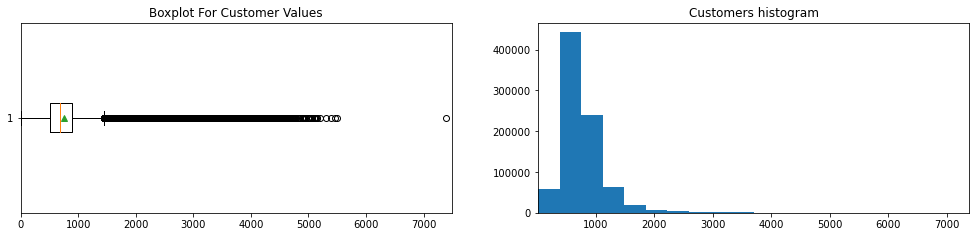

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].boxplot(train_data.Customers, showmeans=True,vert=False)
axes[0].set_xlim(0,max(train_data["Customers"]+100))
axes[0].set_title('Boxplot For Customer Values')
axes[1].hist(train_data.Customers, cumulative=False, bins=20)
axes[1].set_title("Customers histogram")
axes[1].set_xlim((min(train_data.Customers), max(train_data.Customers)))

{"Mean":np.mean(train_data.Customers),"Median":np.median(train_data.Customers)}

In [73]:
print ("{0:.2f}% of the time Rossman are actually having customers more than usual (considered outliers).".format(train_data[train_data.Customers>1500].count()[0]/train_data.shape[0]*100))
print ("{0:.2f}% of the time Rossman are actually having no customers at all.".format(train_data[train_data.Customers==0].count()[0]/train_data.shape[0]*100))

4.37% of the time Rossman are actually having customers more than usual (considered outliers).
0.00% of the time Rossman are actually having no customers at all.


In [77]:
train_data[train_data.Customers>7000]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
825160,817,2,2013-01-22,27190,7388,1,1,0,0


In [78]:
stats.pearsonr(train_data.Customers, train_data.Sales)[0]

0.8235517202000215

#Findings:

We can see similair patterns with the customers column and the Sales column, in fact our pearson correlation factor of 0.82 explains that there is a strong positive correlation between Sales and Customers. In general, the more customers you have in a store, the higher your sales for the day.

We see that on a specific day there was a huge amount of customers in a store,this was due to a big promotion going on. Those specific values are affecting the mean which concludes the difference between a mean of 762 and a median of 676.

We observe a right skewness in both distributions because of the low number of outliers but the high representation of each outlier alone which pushes the distribution to the lefta as seen in both histograms.This typically occurs when the mean is higher than the median.

<b>A closer look at the Store Dataset:</b>

In [96]:
store_data.count(0)/store_data.shape[0] * 100

Store                        100.000000
StoreType                    100.000000
Assortment                   100.000000
CompetitionDistance           99.730942
CompetitionOpenSinceMonth     68.251121
CompetitionOpenSinceYear      68.251121
Promo2                       100.000000
Promo2SinceWeek               51.210762
Promo2SinceYear               51.210762
PromoInterval                 51.210762
dtype: float64

Findings:

The Promo2SinceWeek,Promo2SinceYear and PromoInterval variables has 51% fill rate since they are actually NULL values because there are no continuous promotion for those stores.

Instead for CompetitionOpenSinceMonth and CompetitionOpenSinceYear, it's basically missing data that we're dealing with here (68.25% fill rate), this means that we have the nearest distance of the competitor but miss the date information on when did he actually opened next to the Rossman store.

Let's start the cleansing process by order:
1) CompetitionDistance:¶

In [97]:
store_data[pd.isnull(store_data.CompetitionDistance)] 
#rows with missing values for Competition Distance, only 3 rows with null which makes sense since 99.73% is filled

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Before deciding how to treat this,we know there are infinite ways of filling missing values.
The most common and simplistic approach is to fill it with either the mean or the median of this variable.
Let's quickly have a look at those metrics.

{'Mean': 5404.901079136691,
 'Median': 2325.0,
 'Standard Dev': 7659.7282732764415}

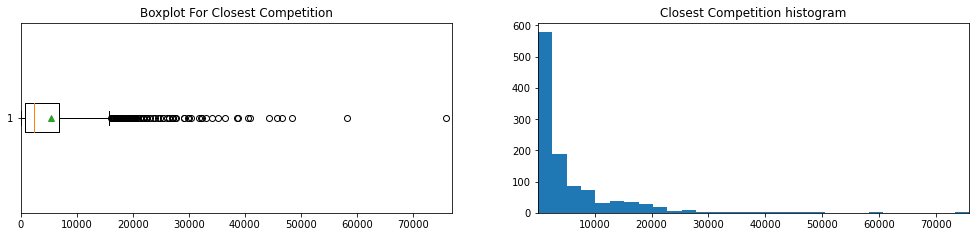

In [100]:
store_data_check_distribution=store_data.drop(store_data[pd.isnull(store_data.CompetitionDistance)].index)
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].boxplot(store_data_check_distribution.CompetitionDistance, showmeans=True,vert=False,)
axes[0].set_xlim(0,max(store_data_check_distribution.CompetitionDistance+1000))
axes[0].set_title('Boxplot For Closest Competition')
axes[1].hist(store_data_check_distribution.CompetitionDistance, cumulative=False, bins=30)
axes[1].set_title("Closest Competition histogram")
axes[1].set_xlim((min(store_data_check_distribution.CompetitionDistance), max(store_data_check_distribution.CompetitionDistance)))
{"Mean":np.nanmean(store_data.CompetitionDistance),"Median":np.nanmedian(store_data.CompetitionDistance),"Standard Dev":np.nanstd(store_data.CompetitionDistance)}#That's what i thought, very different values, let's see why 

We see a highly right skewed distribution for this variable with a significant difference between the mean and the median. This being caused by the amount of disperness in the data with a standard deviation of 7659, higher than the mean and the median.

Solution:

It is realistically better to input the median value to the three Nan stores then the mean since the mean is biased by those outliers.

In [102]:
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(), inplace = True)

2) CompetitionOpenSinceMonth and CompetitionOpenSinceYear?

Since we have no information whatsoever on those missing values and no accurate way of filling those values.
A creative way could be to apply a multilabel classification algorithm and train on the non Nan fields and then predict what could be most probably the month and year for those fields. But this approach is computationally too long.
So for this purpose those fields are going to be assigned to 0 .

In [103]:
store_data.CompetitionOpenSinceMonth.fillna(0, inplace = True)
store_data.CompetitionOpenSinceYear.fillna(0,inplace=True)

<b>3) Promo2SinceWeek, Promo2SinceYear and PromoInterval ?,</b>

In [104]:
#store_data[pd.isnull(df_store.Promo2SinceWeek)]
#store_data[pd.isnull(df_store.Promo2SinceWeek)& (df_store.Promo2==0)]

Findings:

This case is pretty straighforward, all the missing values comes from fields where Promo2=0 which means there are no continuous promotional activities for those stores.
Having no promotion means those fields have to be 0 as well since they are linked to Promo2.

In [105]:
store_data.Promo2SinceWeek.fillna(0,inplace=True)
store_data.Promo2SinceYear.fillna(0,inplace=True)
store_data.PromoInterval.fillna(0,inplace=True)

In [106]:
store_data.count(0)/store_data.shape[0] * 100

Store                        100.0
StoreType                    100.0
Assortment                   100.0
CompetitionDistance          100.0
CompetitionOpenSinceMonth    100.0
CompetitionOpenSinceYear     100.0
Promo2                       100.0
Promo2SinceWeek              100.0
Promo2SinceYear              100.0
PromoInterval                100.0
dtype: float64

Now that we are done with clearing missing values, let's merge the two datasets.

In [109]:
#Left-join the train to the store dataset since .Why?
#Because you want to make sure you have all events even if some of them don't have their store information ( which shouldn't happen)
df_train_store = pd.merge(train_data, store_data, how = 'left', on = 'Store')
df_train_store.head() 
print ("The Train_Store dataset has {} Rows and {} Variables".format(str(df_train_store.shape[0]),str(df_train_store.shape[1]))) 

The Train_Store dataset has 1017209 Rows and 18 Variables


Store Type Analysis:
The best way to asses the performance of a store type is to see what is the sales per customer so that we normalize everything and we get the store that makes its customers spend the most on average.

Let's compare first the total sales of each store type, its average sales and then see how it changes when we add the customers to the equation:

In [110]:
df_train_store['SalesperCustomer']=df_train_store['Sales']/df_train_store['Customers']

In [111]:
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesperCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,8.626118


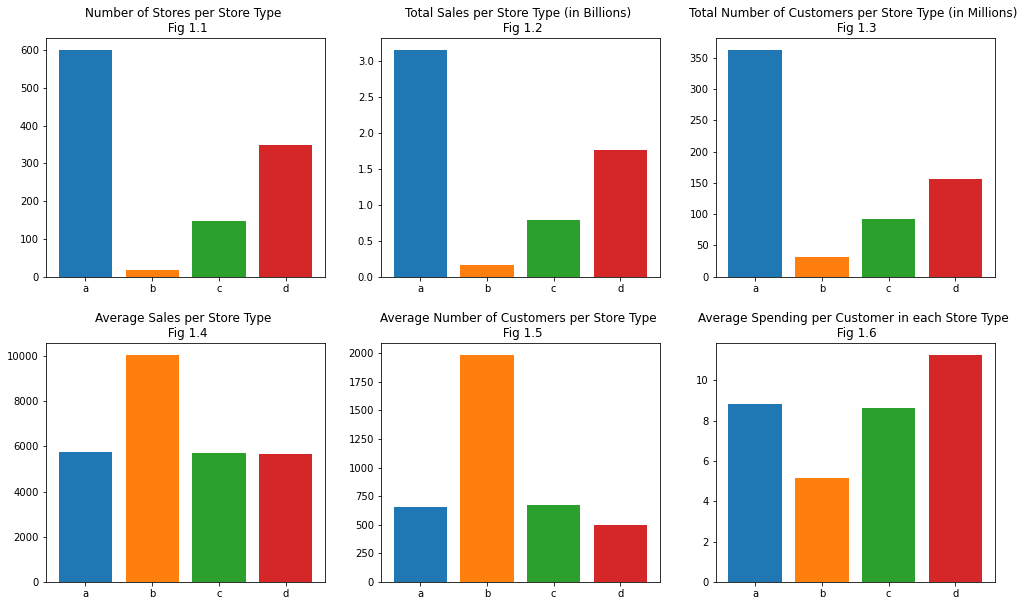

In [115]:
fig, axes = plt.subplots(2, 3,figsize=(17,10) )
palette = itertools.cycle(sns.color_palette(n_colors=4))
plt.subplots_adjust(hspace = 0.28)
#axes[1].df_train_store.groupby(by="StoreType").count().Store.plot(kind='bar')
axes[0,0].bar(store_data.groupby(by="StoreType").count().Store.index,store_data.groupby(by="StoreType").count().Store,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,0].set_title("Number of Stores per Store Type \n Fig 1.1")
axes[0,1].bar(df_train_store.groupby(by="StoreType").sum().Sales.index,df_train_store.groupby(by="StoreType").sum().Sales/1e9,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,1].set_title("Total Sales per Store Type (in Billions) \n Fig 1.2")
axes[0,2].bar(df_train_store.groupby(by="StoreType").sum().Customers.index,df_train_store.groupby(by="StoreType").sum().Customers/1e6,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,2].set_title("Total Number of Customers per Store Type (in Millions) \n Fig 1.3")
axes[1,0].bar(df_train_store.groupby(by="StoreType").sum().Customers.index,df_train_store.groupby(by="StoreType").Sales.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,0].set_title("Average Sales per Store Type \n Fig 1.4")
axes[1,1].bar(df_train_store.groupby(by="StoreType").sum().Customers.index,df_train_store.groupby(by="StoreType").Customers.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,1].set_title("Average Number of Customers per Store Type \n Fig 1.5")
axes[1,2].bar(df_train_store.groupby(by="StoreType").sum().Sales.index,df_train_store.groupby(by="StoreType").SalesperCustomer.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,2].set_title("Average Spending per Customer in each Store Type \n Fig 1.6")
plt.show()

Findings:

From this training set we can see that Storetype A has the highest number of branches,sales and customers from the 4 different storetypes. But this doesn't mean it's the best performing Storetype.

When looking at the average sales and number of customers, we see that actually it is Storetype B who was the highest average Sales and highest average Number of Customers. One assumption could be that if B has only 17 stores but such a high amount of average sales and customers that it is likely hyper Rossman branches whereas A would be smaller in size but much more present.

Surprisingly it is StoreType D who has the highest average spending per Customer, this is probably explained by an average competition distance higher than ther rest which means each customer will buy more since he knows there isn't a lot of similair shops around.

What would help us understand better what's happening is to look for other variables explaining this behaviour like Assortments, Comeptition and Promotions.


Assortments:
As we cited in the description, assortments have three types and each store has a defined type and assortment type:

a means basic things
b means extra things
c means extended things so the highest variety of products.
What could be interesting is to see the relationship between a store type and its respective assortment type.

StoreType  Assortment
a          a             381
           c             221
b          a               7
           b               9
           c               1
c          a              77
           c              71
d          a             128
           c             220
Name: Assortment, dtype: int64

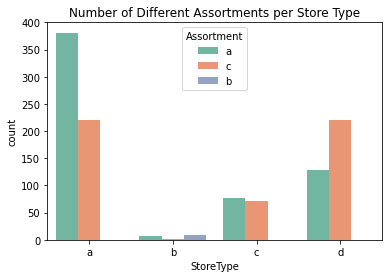

In [116]:
StoretypeXAssortment = sns.countplot(x="StoreType",hue="Assortment",order=["a","b","c","d"], data=store_data,palette=sns.color_palette("Set2", n_colors=3)).set_title("Number of Different Assortments per Store Type")
store_data.groupby(by=["StoreType","Assortment"]).Assortment.count()

In [118]:
df_train_store = pd.read_csv(r'C:\Users\Hp\Downloads/train.csv')

In [119]:
train_data = pd.read_csv(r'C:\Users\Hp\Downloads/train.csv')

In [121]:
store_data = pd.read_csv(r'C:\Users\Hp\Downloads/store.csv')

In [122]:
def plot_bar(df: pd.DataFrame, x_col: str, y_col: str, title: str, xlabel: str, ylabel: str) -> None:
    plt.figure(figsize=(9, 7))
    sns.barplot(data=df, x=x_col, y=y_col)
    plt.title(title, size=18)
    plt.xticks(rotation=60, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.show()

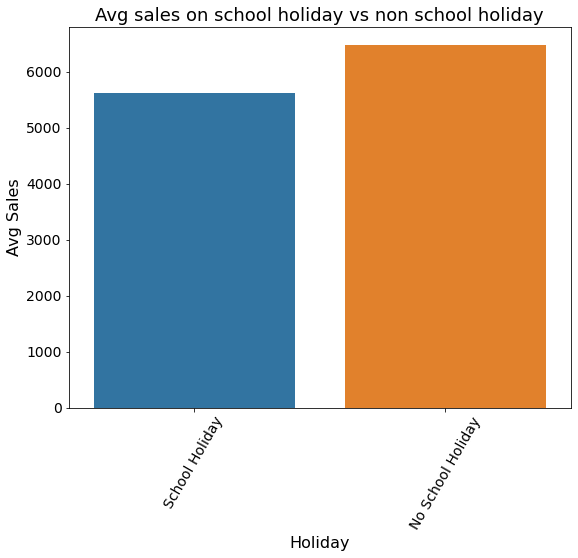

In [123]:
school_df_agg = df_train_store.groupby("SchoolHoliday").agg({"Sales": "mean"}).rename(index={0: "School Holiday", 1:"No School Holiday"})
plot_bar(school_df_agg, school_df_agg.index, "Sales", "Avg sales on school holiday vs non school holiday",
               "Holiday", "Avg Sales")

the overall avg sales non school holiday is a little bit higher

<b>Store Type Analysis:<b/>
The best way to asses the performance of a store type is to see what is the sales per customer so that we normalize everything and we get the store that makes its customers spend the most on average.

Let's compare first the total sales of each store type, its average sales and then see how it changes when we add the customers to the equation:

In [129]:
df_train_store['SalesperCustomer']=df_train_store['Sales']/df_train_store['Customers']

In [131]:
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesperCustomer
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883
1,2,5,2015-07-31,6064,625,1,1,0,1,9.702400
2,3,5,2015-07-31,8314,821,1,1,0,1,10.126675
3,4,5,2015-07-31,13995,1498,1,1,0,1,9.342457
4,5,5,2015-07-31,4822,559,1,1,0,1,8.626118


<b>Promotion:.</b>

In [136]:
df_train_store['Date']=pd.to_datetime(df_train_store['Date'],errors='coerce')

In [137]:
df_train_store['Month']=df_train_store.Date.dt.month
df_train_store['Year']=df_train_store.Date.dt.year

In [138]:
df_train_store.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesperCustomer,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,9.702400,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,10.126675,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,9.342457,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,8.626118,7,2015


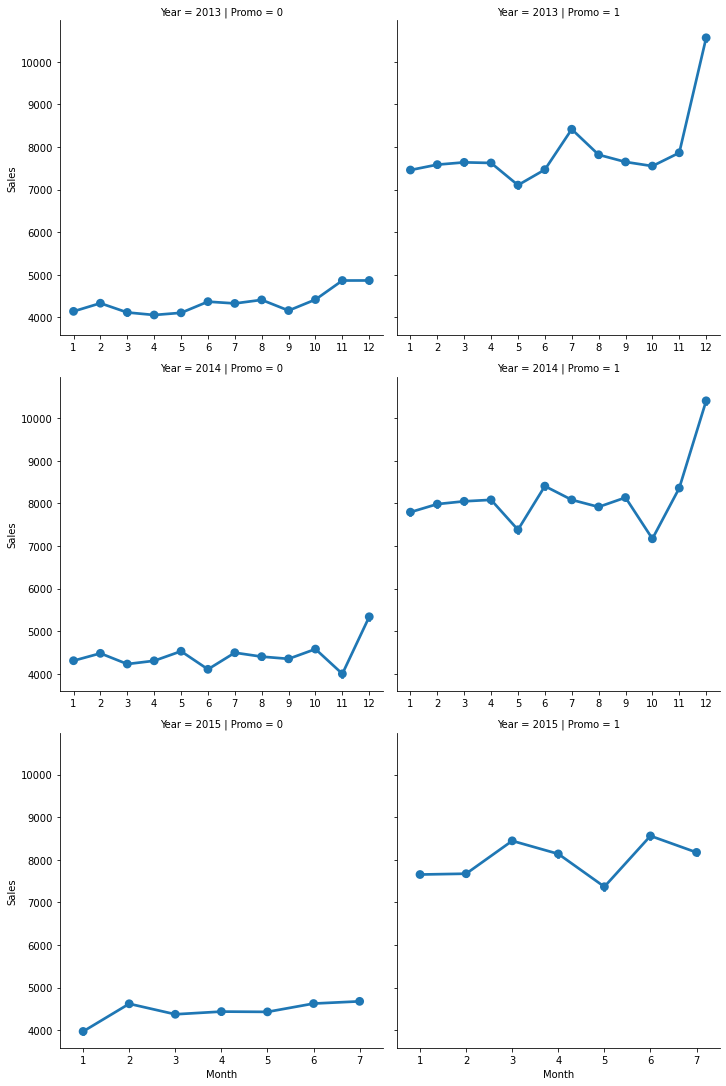

In [142]:
sns.factorplot(data = df_train_store, x ="Month", y = "Sales", 
               col = 'Promo', # per store type in cols
               row = "Year"
              ,sharex=False)

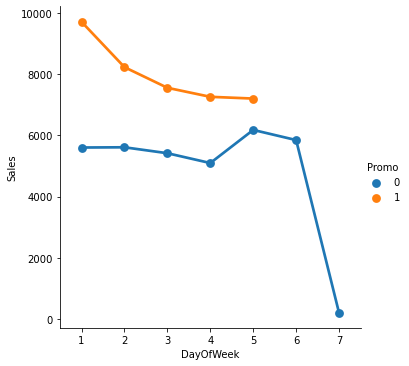

In [143]:
sns.factorplot(data = df_train_store, x ="DayOfWeek", y = "Sales",
                hue='Promo'
              ,sharex=False)

In [144]:
print ("Number of Stores opened on Sundays:{}" .format(df_train_store[(df_train_store.Open == 1) & (df_train_store.DayOfWeek == 7)]['Store'].unique().shape[0]))

Number of Stores opened on Sundays:33


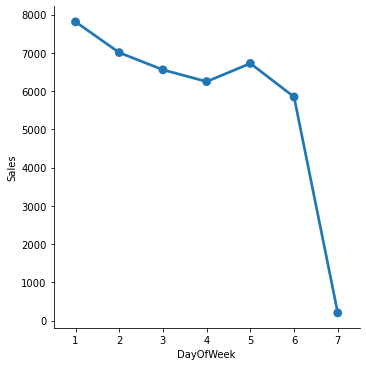

In [145]:
sns.factorplot(data = df_train_store, x ="DayOfWeek", y = "Sales",
              sharex=False)

Findings:
* For Sunday to have such a high peak is understandable, since a very few stores opens on Sundays (only 33);if anyone needs anything urgently and don't have the time to get it during the week, he will have to do some distance to get to the open ones even if it's not close to his house. This means that those 33 open stores on Sunday actually accounts for the potential demand if all Rossman Stores were closed on Sundays. This clearly shows us how important it is for stores to be opened on Sundays.